In [20]:
pip install "gluonts[torch]"

  Using cached fsspec-2024.9.0-py3-none-any.whl.metadata (11 kB)
  Using cached lightning_utilities-0.11.7-py3-none-any.whl.metadata (5.2 kB)
  Using cached torchmetrics-1.4.2-py3-none-any.whl.metadata (19 kB)
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Using cached filelock-3.16.0-py3-none-any.whl.metadata (3.0 kB)
  Using cached sympy-1.13.2-py3-none-any.whl.metadata (12 kB)
  Using cached networkx-3.3-py3-none-any.whl.metadata (5.1 kB)
  Using cached jinja2-3.1.4-py3-none-any.whl.metadata (2.6 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-n

In [3]:
pip install matplotlib

  Using cached matplotlib-3.9.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
  Using cached contourpy-1.3.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.4 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.53.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (162 kB)
  Using cached kiwisolver-1.4.7-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.3 kB)
  Using cached pillow-10.4.0-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (9.2 kB)
  Using cached pyparsing-3.1.4-py3-none-any.whl.metadata (5.1 kB)
Using cached matplotlib-3.9.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (8.3 MB)
Using cached contourpy-1.3.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (323 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
Using cached fonttools-4.53.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (4.9 MB)
Using

In [6]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from gluonts.dataset.repository import get_dataset, dataset_names
from gluonts.dataset.util import to_pandas

/home/plealm/Documentos/Unal/Maestria/1_Semestre/Series_Temporales/codigo/acciones/.venv/lib/python3.11/site-packages/gluonts/json.py:102: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


In [7]:
print(f"Available datasets: {dataset_names}")

Available datasets: ['constant', 'exchange_rate', 'solar-energy', 'electricity', 'traffic', 'exchange_rate_nips', 'electricity_nips', 'traffic_nips', 'solar_nips', 'wiki2000_nips', 'wiki-rolling_nips', 'taxi_30min', 'kaggle_web_traffic_with_missing', 'kaggle_web_traffic_without_missing', 'kaggle_web_traffic_weekly', 'm1_yearly', 'm1_quarterly', 'm1_monthly', 'nn5_daily_with_missing', 'nn5_daily_without_missing', 'nn5_weekly', 'tourism_monthly', 'tourism_quarterly', 'tourism_yearly', 'cif_2016', 'london_smart_meters_without_missing', 'wind_farms_without_missing', 'car_parts_without_missing', 'dominick', 'fred_md', 'pedestrian_counts', 'hospital', 'covid_deaths', 'kdd_cup_2018_without_missing', 'weather', 'm3_monthly', 'm3_quarterly', 'm3_yearly', 'm3_other', 'm4_hourly', 'm4_daily', 'm4_weekly', 'm4_monthly', 'm4_quarterly', 'm4_yearly', 'm5', 'uber_tlc_daily', 'uber_tlc_hourly', 'airpassengers', 'australian_electricity_demand', 'electricity_hourly', 'electricity_weekly', 'rideshare_wit

In [8]:
dataset = get_dataset("m4_hourly")

/home/plealm/Documentos/Unal/Maestria/1_Semestre/Series_Temporales/codigo/acciones/.venv/lib/python3.11/site-packages/gluonts/dataset/common.py:263: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  return pd.Period(val, freq)


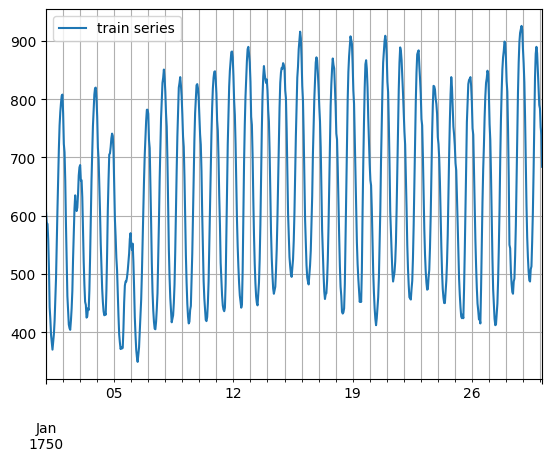

In [9]:
entry = next(iter(dataset.train))
train_series = to_pandas(entry)
train_series.plot()
plt.grid(which="both")
plt.legend(["train series"], loc="upper left")
plt.show()

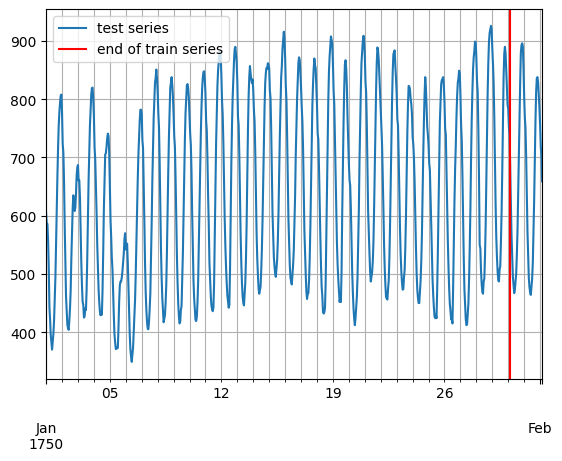

In [10]:
entry = next(iter(dataset.test))
test_series = to_pandas(entry)
test_series.plot()
plt.axvline(train_series.index[-1], color="r")  # end of train dataset
plt.grid(which="both")
plt.legend(["test series", "end of train series"], loc="upper left")
plt.show()

In [11]:
from gluonts.mx import SimpleFeedForwardEstimator, Trainer

estimator = SimpleFeedForwardEstimator(
    num_hidden_dimensions=[10],
    prediction_length=dataset.metadata.prediction_length,
    context_length=100,
    trainer=Trainer(ctx="cpu", epochs=5, learning_rate=1e-3, num_batches_per_epoch=100),
)

In [12]:
from gluonts.evaluation import make_evaluation_predictions

predictor = estimator.train(dataset.train)

forecast_it, ts_it = make_evaluation_predictions(
    dataset=dataset.test,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)

100%|██████████| 100/100 [00:02<00:00, 49.88it/s, epoch=5/5, avg_epoch_loss=4.77]


In [13]:
forecasts = list(forecast_it)
tss = list(ts_it)

In [16]:
ts_entry = tss[0]
forecast_entry = forecasts[0]

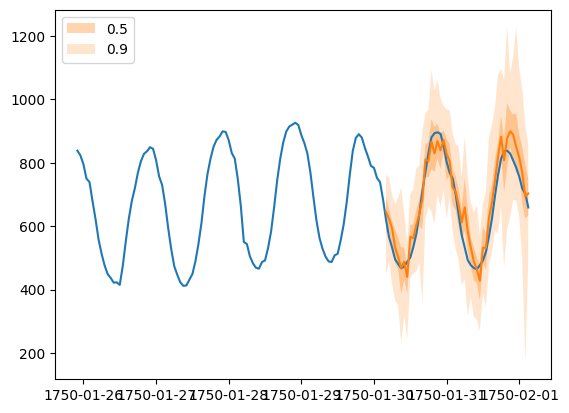

In [17]:
plt.plot(ts_entry[-150:].to_timestamp())
forecast_entry.plot(show_label=True)
plt.legend()

/home/plealm/Documentos/Unal/Maestria/1_Semestre/Series_Temporales/codigo/acciones/.venv/lib/python3.11/site-packages/gluonts/time_feature/lag.py:104: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  offset = to_offset(freq_str)
/home/plealm/Documentos/Unal/Maestria/1_Semestre/Series_Temporales/codigo/acciones/.venv/lib/python3.11/site-packages/gluonts/time_feature/_base.py:249: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  offset = to_offset(freq_str)
100%|██████████| 100/100 [00:03<00:00, 32.32it/s, epoch=50/50, avg_epoch_loss=1.74]
/home/plealm/Documentos/Unal/Maestria/1_Semestre/Series_Temporales/codigo/acciones/.venv/lib/python3.11/site-packages/gluonts/dataset/common.py:255: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ProcessDataEntry(to_offset(freq), one_dim_target, use_timestamp),


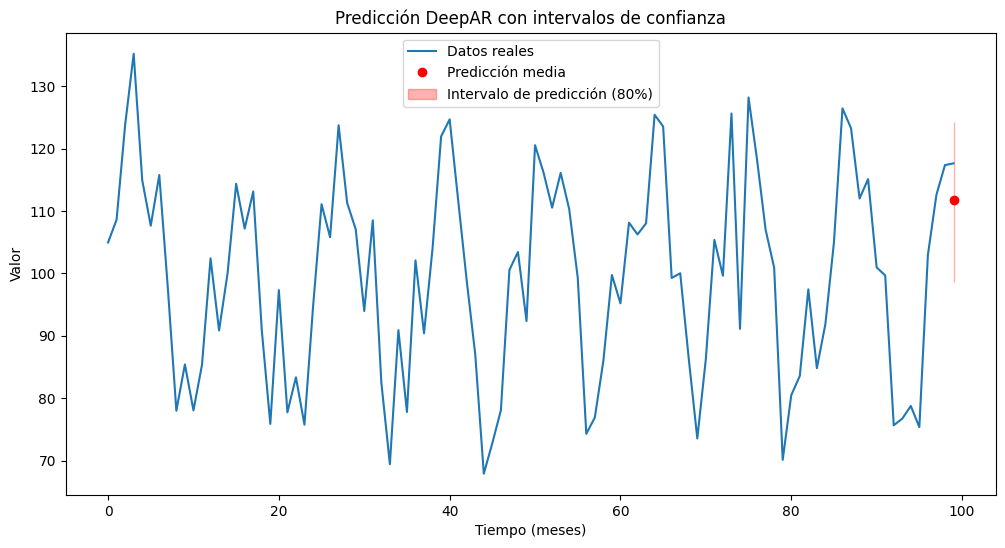

Predicción media: 111.74
Intervalo de predicción (80%): [98.69, 124.24]


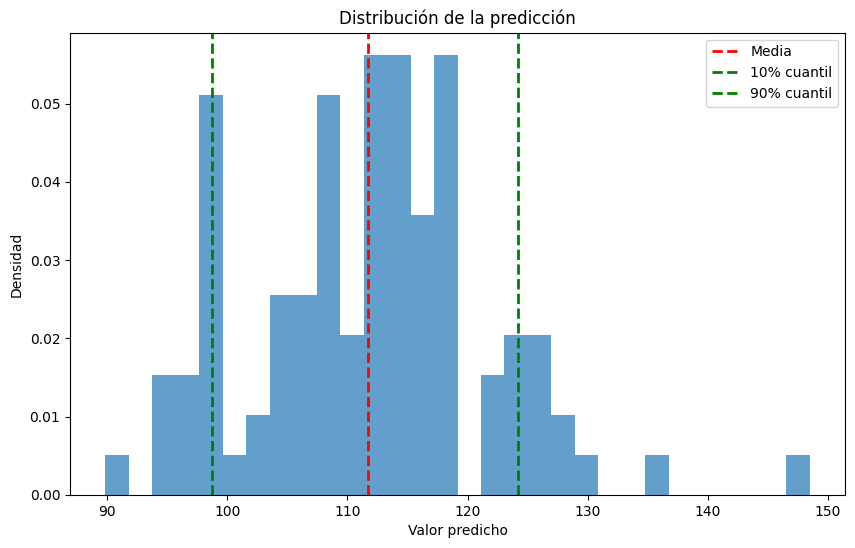

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mxnet as mx

from gluonts.dataset.common import ListDataset
from gluonts.mx.model.deepar import DeepAREstimator
from gluonts.mx.trainer import Trainer
from gluonts.evaluation.backtest import make_evaluation_predictions

# Configurar semilla para reproducibilidad
np.random.seed(42)
mx.random.seed(42)

# Generar serie de tiempo simulada
start_date = pd.Timestamp("2019-01-01")
num_samples = 100
time_series = np.random.normal(loc=100, scale=10, size=num_samples) + \
              np.sin(np.arange(num_samples) * 2 * np.pi / 12) * 20  # Patrón anual

# Crear dataset
train_ds = ListDataset(
    [{"start": start_date, "target": time_series[:-1]}],
    freq="M"
)

# Configurar y entrenar el modelo DeepAR
estimator = DeepAREstimator(
    freq="M",
    prediction_length=1,
    trainer=Trainer(epochs=50, num_batches_per_epoch=100)
)
predictor = estimator.train(train_ds)

# Realizar predicciones
forecast_it, ts_it = make_evaluation_predictions(
    dataset=ListDataset(
        [{"start": start_date, "target": time_series}],
        freq="M"
    ),
    predictor=predictor,
    num_samples=100
)
forecasts = list(forecast_it)
tss = list(ts_it)

# Extraer la media y los intervalos de confianza
mean_forecast = forecasts[0].mean
lower_quantiles = forecasts[0].quantile(0.1)
upper_quantiles = forecasts[0].quantile(0.9)

# Visualizar resultados
plt.figure(figsize=(12, 6))
plt.plot(time_series, label='Datos reales')
plt.plot(range(num_samples-1, num_samples), mean_forecast, 'ro', label='Predicción media')
plt.fill_between([num_samples-1], lower_quantiles, upper_quantiles, color='r', alpha=0.3, label='Intervalo de predicción (80%)')
plt.legend()
plt.title('Predicción DeepAR con intervalos de confianza')
plt.xlabel('Tiempo (meses)')
plt.ylabel('Valor')
plt.show()

# Mostrar predicción probabilística
print(f"Predicción media: {mean_forecast[0]:.2f}")
print(f"Intervalo de predicción (80%): [{lower_quantiles[0]:.2f}, {upper_quantiles[0]:.2f}]")

# Histograma de las muestras de predicción
samples = forecasts[0].samples
plt.figure(figsize=(10, 6))
plt.hist(samples, bins=30, density=True, alpha=0.7)
plt.axvline(mean_forecast[0], color='r', linestyle='dashed', linewidth=2, label='Media')
plt.axvline(lower_quantiles[0], color='g', linestyle='dashed', linewidth=2, label='10% cuantil')
plt.axvline(upper_quantiles[0], color='g', linestyle='dashed', linewidth=2, label='90% cuantil')
plt.title('Distribución de la predicción')
plt.xlabel('Valor predicho')
plt.ylabel('Densidad')
plt.legend()
plt.show()